# Metagenomics

This Jupyternotebook is focusing on the analysis of metagenomics datasets, which allow us to get a insight into the composition and the functional potential of microbial communities in our data.

PICRUST2  maps 16S rRNA gene sequences to their nearest matching whole genome sequences. The function produces feature tables with the information of KEGG orthologs, enzymes and entire pathways to compare the samples and condition of the metatdata among themselves.

**Notebook overview:**

[0. Setup](#setup)<br>
[1. Functional Inference](#picrust)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Enriched KEGG orthologs alcohol consumption](#ipath)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Enriched pathways alcohol consumption](#metacyc)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.3 Enriched KEGG orthologs alcohol frequency](#metacyc_af)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.4 Enriched pathways alcohol frequency](#metacyc_af)<br>
[2. Milk products](#milk)<br>
[3. Mediterranean Diet](#mediterranean)<br>
[4. Poultry](#poultry)<br>
[5. Meat](#meat)<br>
[6. Vegetarian Diet](#vegi)<br>
[7. Gluten](#gluten)<br>
[8. Sweet Tooth](#sweet)<br>
[9. Fermented or Probiotics](#probiotic)<br>
[XY. Test for Rest](#rest)<br>

Reference: PICRUST2 [GitHub wiki](https://github.com/picrust/picrust2/wiki) and [Nature Biotechnology article](https://doi.org/10.1038/s41587-020-0548-6).

<a id='setup'></a>
## 0. Setup

In [155]:
import os
import pandas as pd
import qiime2 as q2
import requests
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from qiime2 import Visualization

data_dir = 'project_data'
    
%matplotlib inline

In [2]:
def fetch_ipath(ids: list, img_output_path: str, verbose: bool = False):
    """Fetches a enriched pathways map from iPATH3 for given IDs."""
    url = 'https://pathways.embl.de/mapping.cgi'
    
    # remove colon from EC names
    if ':' in ids[0]:
        ids = [x.replace(':', '') for x in ids]
    
    if verbose:
        print(f'Fetching iPATH3 diagram for ids: {ids}')
    params = {
        'default_opacity': 0.6,
        'export_type': 'svg',
        'selection': '\n'.join(ids)
    }   
    response = requests.get(url=url, params=params)
    
    with open(img_output_path, 'wb') as img:
        img.write(response.content)

In [3]:
# path to the picrust2 conda environment - do not change!
picrust_env = '/opt/conda/envs/picrust2/bin'

Download the `FeatureData[Sequence]` from our data which was made in the FirstLook.ipynb:

In [4]:
! wget -nv -O $data_dir/rep-seqs.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza'

2022-11-28 15:50:29 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza [390624/390624] -> "project_data/rep-seqs.qza" [1]


Download the `FeatureTable[Frequency]` containing a mapping of the dereplicated sequences to samples from our data which was made in the FirstLook.ipynb:

In [5]:
! qiime tools peek $data_dir/rep-seqs.qza

UUID:        fd06ce7d-7b2d-4485-afda-fa50da61e9f4
Type:        FeatureData[Sequence]
Data format: DNASequencesDirectoryFormat


In [6]:
! wget -nv -O $data_dir/table.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza'

2022-11-28 15:50:34 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza [504534/504534] -> "project_data/table.qza" [1]


Download the `Metadata` containing metadata to samples from our data:

In [7]:
! wget -nv -O $data_dir/metadata.tsv 'https://polybox.ethz.ch/index.php/s/QqbHeUIpIR0okB8/download'

2022-11-28 15:50:39 URL:https://polybox.ethz.ch/index.php/s/QqbHeUIpIR0okB8/download [300302/300302] -> "project_data/metadata.tsv" [1]


<a id='picrust'></a>
## 1. Functional inference

As mentioned in the introduction, we are using Picrust 2 to simulate metagenome data from our 16S dataset. Execute the command below to run picrust2 - it will take approximately 30-40 minutes.

In [13]:
%%script env picrust_env="$picrust_env" data_dir="$data_dir" bash

# append the env location to PATH so that qiime
# can find all required executables
export PATH=$picrust_env:$PATH


$picrust_env/qiime picrust2 full-pipeline \
    --i-seq $data_dir/rep-seqs.qza \
    --i-table $data_dir/table.qza \
    --output-dir $data_dir/picrust2_results \
    --p-placement-tool sepp \
    --p-threads 2 \
    --p-hsp-method pic \
    --p-max-nsti 2 --verbose

/opt/conda/envs/picrust2/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
/opt/conda/envs/picrust2/bin
project_data
Saved FeatureTable[Frequency] to: project_data/picrust2_results/ko_metagenome.qza
Saved FeatureTable[Frequency] to: project_data/picrust2_results/ec_metagenome.qza
Saved FeatureTable[Frequency] to: project_data/picrust2_results/pathway_abundance.qza


Warning - 115 input sequences aligned poorly to reference sequences (--min_align option specified a minimum proportion of 0.8 aligning to reference sequences). These input sequences will not be placed and will be excluded from downstream steps.

This is the set of poorly aligned input sequences to be excluded: 13f72db00c0dbaa8958b9f7918f0b374, 07beb5cc8e914bcdb53a22bb47519c6f, 000fa3dd1e0addc3fe1e3b5d1008afe8, 94346c6d9a95d3b3ae8cc5199de67117, 879643dd982eb501f3c81fca990fd518, acb8def29a97a1c91b3fc3a21f2caf2b, b957bbc0b2cf69471ecf66e8ad3e04bc, aff251a2cb898bb774dbdb48905421cb, fbb21b0edc5b0ef81226200b39c869f6, 70e4caa9982037a944a5d98bf98d55f8, 9ce8bef85c4979f8b7bc3cac7ed448c3, b4eb3cde9bea75d4b44aa58ca81582c0, cd4a519b47d3968e0691867615a5c176, 50494e8139cc7865daf756431a9ddbc4, 6b3d79b96bbe4081267cbf253f6acf4a, 2d156bf28e5958f61156702359c1bbc9, d59db3377c485ff138fab36dfff0829a, cd0b6534edf1e39f840043cc9ff16245, b53340e67fe74981e67adddc676e0a70, aaf3da224d70d78e682e45aee3ffdd11, ea8eb307

tab = q2.Artifact.load('project_data/picrust2_results/pathway_abundance_abund.qza')
tab = tab.view(pd.DataFrame)
metadata.index = metadata.index.astype(str)In the `picrust2_results` subdirectory we get 3 artifacts - all of them are of the `FeatureTable[Frequency]` semantic type and hold abundance information for various functional features:

1. KO metagenome - abundances of [KEGG](https://www.kegg.jp) orthologs
2. EC metagenome - abundance of [enzymes](https://www.brenda-enzymes.org)
3. MetaCyc pathways - abundance of [MetaCyc](https://metacyc.org) pathways

Checking for the values of the metadata: 

In [166]:
metadata = pd.read_csv(f'{data_dir}/metadata.tsv', sep='\t', header=0, index_col=0)
metadata.index = metadata.index.astype(float)
for col in metadata.columns:
    print(col)

GEN_age_cat
GEN_age_corrected
GEN_bmi_cat
GEN_bmi_corrected
GEN_cat
GEN_collection_timestamp
GEN_country
GEN_dog
GEN_elevation
GEN_geo_loc_name
GEN_height_cm
GEN_host_common_name
GEN_last_move
GEN_last_travel
GEN_latitude
GEN_level_of_education
GEN_longitude
GEN_race
GEN_sample_type
GEN_sex
GEN_weight_kg
NUT_alcohol_consumption
NUT_alcohol_frequency
NUT_alcohol_types_beercider
NUT_alcohol_types_red_wine
NUT_alcohol_types_sour_beers
NUT_alcohol_types_spiritshard_alcohol
NUT_alcohol_types_unspecified
NUT_alcohol_types_white_wine
NUT_artificial_sweeteners
NUT_diet_type
NUT_drinks_per_session
NUT_fed_as_infant
NUT_fermented_plant_frequency
NUT_frozen_dessert_frequency
NUT_fruit_frequency
NUT_gluten
NUT_high_fat_red_meat_frequency
NUT_homecooked_meals_frequency
NUT_lowgrain_diet_type
NUT_meat_eggs_frequency
NUT_milk_cheese_frequency
NUT_milk_substitute_frequency
NUT_olive_oil
NUT_poultry_frequency
NUT_prepared_meals_frequency
NUT_probiotic_frequency
NUT_red_meat_frequency
NUT_salted_snacks_

Let's look at the metadata briefly to see what kind of categories we have available:

In [9]:
! qiime metadata tabulate \
    --m-input-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/metadata.qzv

Saved Visualization to: project_data/metadata.qzv


In [10]:
Visualization.load(f'{data_dir}/metadata.qzv')

<visualization: Visualization uuid: da6f7794-fdf5-4c2a-b387-de64278373b4>

Now, we can read in all three artifacts using QIIME 2 Python API - we can view them as DataFrames:

In [5]:
ko = q2.Artifact.load(f'{data_dir}/picrust2_results/ko_metagenome.qza').view(pd.DataFrame)
ec = q2.Artifact.load(f'{data_dir}/picrust2_results/ec_metagenome.qza').view(pd.DataFrame)
pa = q2.Artifact.load(f'{data_dir}/picrust2_results/pathway_abundance.qza').view(pd.DataFrame)
ko.index = ko.index.astype(float)
ec.index = ec.index.astype(float)
pa.index = pa.index.astype(float)

<a id='ipath'></a>
### 1.1 Enriched KEGG orthologs visualization for Alcohol

Find the most abundant KEGG orthologs and plot them for both, where the sample alcohol cunsumption is .

We start by merging our feature table with the treatment column (`NUT_alcohol_consumption`) from the metadata:

In [36]:
ko_meta = ko.merge(metadata[['NUT_alcohol_consumption']], left_index=True, right_index=True)
ec_meta = ec.merge(metadata[['NUT_alcohol_consumption']], left_index=True, right_index=True)
pa_meta = pa.merge(metadata[['NUT_alcohol_consumption']], left_index=True, right_index=True)

Next, we will calculate an average abundance of each KO, EC and pathway in each group (alcohol consumption vs. no alcohol consumption):

In [9]:
# collapse samples per sample_type - calculate average abundance
ko_meta_avg = ko_meta.groupby('NUT_alcohol_consumption').mean()
ec_meta_avg = ec_meta.groupby('NUT_alcohol_consumption').mean()
pa_meta_avg = pa_meta.groupby('NUT_alcohol_consumption').mean()

In [10]:
ko_meta_avg.head()

,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,K00011,...,K19776,K19777,K19778,K19779,K19780,K19784,K19785,K19788,K19789,K19791
NUT_alcohol_consumption,,,,,,,,,,,,,,,,,,,,,
False,3162.421122,68.691026,4796.981177,398.456162,3772.020015,83.825277,4324.14981,1467.899032,2903.594500,0.339969,...,1083.124950,718.306041,573.952036,94.495166,137.206914,1247.168509,3.566936e-127,0.000026,1006.961259,0.006508
True,3181.198018,73.266389,4909.399083,400.607382,3893.175186,51.285504,4566.19005,1400.650732,2557.094055,0.792130,...,1075.325431,688.104082,612.494259,103.840925,109.865976,1059.402351,7.638711e-06,0.002091,922.806781,0.005347


We are looking for the most abundant features in each table:

In [11]:
# find top x% of the most abundant KOs, ECs and pathways in each sample type
def find_most_abundant(df: pd.DataFrame, frac):
    if 0 < frac < 1:
        frac = int(frac * len(df.columns))
    print(f'Saving {frac} most abundant features...')
    most_abundant = {
        smp: df.loc[smp, :].sort_values(ascending=False)[:frac]
        for smp in df.index
    }
    return most_abundant

ko_most_abundant = find_most_abundant(ko_meta_avg, 0.01)
ec_most_abundant = find_most_abundant(ec_meta_avg, 0.03)
pa_most_abundant = find_most_abundant(pa_meta_avg, 5)

Saving 101 most abundant features...
Saving 85 most abundant features...
Saving 5 most abundant features...


In [12]:
print(f'10 most abundant KOs in the alcohole consumption group are: {ko_most_abundant[True].index[:10].tolist()}\n'
      f'10 most abundant KOs in the non-alcohole consumption group are: {ko_most_abundant[False].index[:10].tolist()}\n')

10 most abundant KOs in the alcohole consumption group are: ['K03088', 'K01990', 'K02004', 'K06147', 'K01992', 'K02003', 'K02529', 'K07024', 'K03497', 'K02015']
10 most abundant KOs in the non-alcohole consumption group are: ['K03088', 'K01990', 'K02004', 'K01992', 'K06147', 'K02003', 'K02529', 'K07024', 'K00059', 'K02015']



To visualize the KOs and ECs [Interactive Pathway Explorer](https://pathways.embl.de) (iPath 3).

In [35]:
for smp in ko_most_abundant.keys():
    fetch_ipath(ko_most_abundant[smp].index.tolist(), f'{data_dir}/picrust2_results/kos_{smp}.svg')
    fetch_ipath(ec_most_abundant[smp].index.str.replace(':', '').tolist(), f'{data_dir}/picrust2_results/ecs_{smp}.svg')

This should have fetched 4 pathway maps: one map per sample group (alcohol cons vs. non-alcohol cons) and one map per feature table (KO vs. EC).

<a id='metacyc'></a>
### 1.2 Enriched pathways in Alcohol consumption

We can also look at the most abundant pathways in both sample groups. 

In [13]:
print(f'4 most abundant pathways in the alcohol consumption group are: {pa_most_abundant[True].index[:4].tolist()}\n'
      f'4 most abundant pathways in the non-alcohol consumption are: {pa_most_abundant[False].index[:4].tolist()}\n')

4 most abundant pathways in the alcohol consumption group are: ['NONOXIPENT-PWY', 'PWY-7111', 'PWY-5101', 'PWY-7663']
4 most abundant pathways in the non-alcohol consumptiopn are: ['NONOXIPENT-PWY', 'PWY-7111', 'PWY-5101', 'PWY-7663']



Find whether there are pathways that differ significantly between samples with and without alcohol consumption.

In [43]:
! qiime composition add-pseudocount \
    --i-table $data_dir/picrust2_results/pathway_abundance.qza \
    --o-composition-table $data_dir/picrust2_results/pathway_abundance_abund.qza

Saved FeatureTable[Composition] to: project_data/picrust2_results/pathway_abundance_abund.qza


In [22]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_alcohol_consumption' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_alc.qzv

Saved Visualization to: project_data/pa_ancom_alc.qzv


In [37]:
Visualization.load(f'{data_dir}/pa_ancom_alc.qzv')

<visualization: Visualization uuid: 55566aa4-d986-4abc-aff2-9492ff900e61>

ANCOM statistical result highest W value:  
PWY-6165 -> 59  
PWY-6660 -> 9  
PWY-1622 -> 7

<a id='ipath_af'></a>
### 1.3 Enriched KEGG orthologs visualization for different alcohol frequency

We merge the feature table with the treatment column (`NUT_alcohol_frequency`) from the metadata:

In [23]:
ko_meta = ko.merge(metadata[['NUT_alcohol_frequency']], left_index=True, right_index=True)
ec_meta = ec.merge(metadata[['NUT_alcohol_frequency']], left_index=True, right_index=True)
pa_meta = pa.merge(metadata[['NUT_alcohol_frequency']], left_index=True, right_index=True)

In [24]:
# collapse samples per sample_type - calculate average abundance

ko_meta_avg = ko_meta.groupby('NUT_alcohol_frequency').mean()
ec_meta_avg = ec_meta.groupby('NUT_alcohol_frequency').mean()
pa_meta_avg = pa_meta.groupby('NUT_alcohol_frequency').mean()

In [25]:
ko_meta_avg.head()

,K00001,K00002,K00003,K00004,K00005,K00007,K00008,K00009,K00010,K00011,...,K19776,K19777,K19778,K19779,K19780,K19784,K19785,K19788,K19789,K19791
NUT_alcohol_frequency,,,,,,,,,,,,,,,,,,,,,
Daily,3103.902417,93.084658,4909.149528,337.034408,3683.977036,53.287276,4503.409934,1324.398596,2598.638961,0.430046,...,972.654503,597.195147,630.746732,102.067777,106.612546,903.252986,8.761902e-132,1.620505e-61,837.353006,0.002665
Never,3201.048511,67.911429,4790.008823,396.439968,3815.666170,87.632092,4327.025209,1497.076452,2907.576424,0.342780,...,1111.760260,681.172238,588.084755,96.533759,140.359385,1254.594809,3.740088e-127,2.680143e-05,1034.834305,0.006824
Not provided,2366.696894,84.750719,4940.611669,439.989763,2872.909217,5.404876,4264.916592,866.844192,2821.566868,0.282074,...,493.237565,1483.262377,282.818012,52.500146,72.266026,1094.186712,0.000000e+00,0.000000e+00,432.776499,0.000000
Occasionally,3074.590209,68.465976,4812.337425,407.825844,3837.777605,42.740666,4465.330802,1440.851550,2521.768249,0.838372,...,1054.433114,689.014003,610.053028,102.565229,110.396286,1053.374853,2.556504e-05,4.687264e-57,923.058790,0.003441
Rarely,3244.193427,64.865684,4672.445161,410.778882,3812.624114,63.965862,4506.626631,1422.700524,2594.140575,0.574958,...,1069.795229,655.609009,545.815746,96.481738,101.020587,1052.407687,4.452490e-132,8.234833e-62,934.614449,0.004088


Finally, let's find the most abundant features in each table:

In [26]:
# find top x% of the most abundant KOs, ECs and pathways in each sample type

def find_most_abundant(df: pd.DataFrame, frac):
    if 0 < frac < 1:
        frac = int(frac * len(df.columns))
    print(f'Saving {frac} most abundant features...')
    most_abundant = {
        smp: df.loc[smp, :].sort_values(ascending=False)[:frac]
        for smp in df.index
    }
    return most_abundant

ko_most_abundant = find_most_abundant(ko_meta_avg, 0.01)
ec_most_abundant = find_most_abundant(ec_meta_avg, 0.03)
pa_most_abundant = find_most_abundant(pa_meta_avg, 5)

Saving 101 most abundant features...
Saving 85 most abundant features...
Saving 5 most abundant features...


In [27]:
print(f'5 most abundant KOs in the never alcohole consumption group are: {ko_most_abundant["Never"].index[:5].tolist()}\n'
      f'5 most abundant KOs in the Daily alcohole consumption group are: {ko_most_abundant["Daily"].index[:5].tolist()}\n'
      f'5 most abundant KOs in the Occasionally alcohole consumption group are: {ko_most_abundant["Occasionally"].index[:5].tolist()}\n'
      f'5 most abundant KOs in the Rarely alcohole consumption group are: {ko_most_abundant["Rarely"].index[:5].tolist()}\n'
     )

5 most abundant KOs in the never alcohole consumption group are: ['K03088', 'K01990', 'K02004', 'K01992', 'K06147']
5 most abundant KOs in the Daily alcohole consumption group are: ['K03088', 'K01990', 'K02004', 'K06147', 'K01992']
5 most abundant KOs in the Occasionally alcohole consumption group are: ['K03088', 'K01990', 'K02004', 'K01992', 'K06147']
5 most abundant KOs in the Rarely alcohole consumption group are: ['K03088', 'K01990', 'K02004', 'K06147', 'K01992']



In [28]:
for smp in ko_most_abundant.keys():
    fetch_ipath(ko_most_abundant[smp].index.tolist(), f'{data_dir}/picrust2_results/kos_{smp}.svg')
    fetch_ipath(ec_most_abundant[smp].index.str.replace(':', '').tolist(), f'{data_dir}/picrust2_results/ecs_{smp}.svg')
    

<a id='metacyc_af'></a>
### 1.4 Enriched pathways in different alcohol frequency


In [32]:
print(f'4 most abundant pathways in the Never alcohol consumption group are: {pa_most_abundant["Never"].index[:4].tolist()}\n'
      f'4 most abundant pathways in the Daily non-alcohol consumption are: {pa_most_abundant["Daily"].index[:4].tolist()}\n'
     f'4 most abundant pathways in the Occasionally non-alcohol consumption are: {pa_most_abundant["Occasionally"].index[:4].tolist()}\n'
     f'4 most abundant pathways in the Rarely non-alcohol consumption are: {pa_most_abundant["Rarely"].index[:4].tolist()}\n'
     )

4 most abundant pathways in the Never alcohol consumption group are: ['NONOXIPENT-PWY', 'PWY-7111', 'PWY-5101', 'PWY-7663']
4 most abundant pathways in the Daily non-alcohol consumption are: ['NONOXIPENT-PWY', 'PWY-7111', 'PWY-5101', 'PWY-6737']
4 most abundant pathways in the Occasionally non-alcohol consumption are: ['NONOXIPENT-PWY', 'PWY-7111', 'PWY-5101', 'PWY-7663']
4 most abundant pathways in the Rarely non-alcohol consumption are: ['NONOXIPENT-PWY', 'PWY-7111', 'PWY-5101', 'PWY-7663']



Find whether there are pathways that differ significantly between samples with and without alcohol consumption.

In [43]:
! qiime composition add-pseudocount \
    --i-table $data_dir/picrust2_results/pathway_abundance.qza \
    --o-composition-table $data_dir/picrust2_results/pathway_abundance_abund.qza

Saved FeatureTable[Composition] to: project_data/picrust2_results/pathway_abundance_abund.qza


Load the pathway_abundance_abund.qza Feature Table to later visualize the outcome of the significant pathways.

In [189]:
tab = q2.Artifact.load('project_data/picrust2_results/pathway_abundance_abund.qza')
tab = tab.view(pd.DataFrame)
metadata.index = metadata.index.astype(str)

In [33]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_alcohol_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_alc_freq.qzv

Saved Visualization to: project_data/pa_ancom_alc_freq.qzv


In [38]:
Visualization.load(f'{data_dir}/pa_ancom_alc_freq.qzv')

<visualization: Visualization uuid: 22a3728e-56e2-4643-a6e2-45ce978fc354>

ANCOM statistical result highest W value:  
PWY-5198 -> 63  
PWY-6165 -> 62  
PWY-7354 -> 58  
PWY-1622 ->10

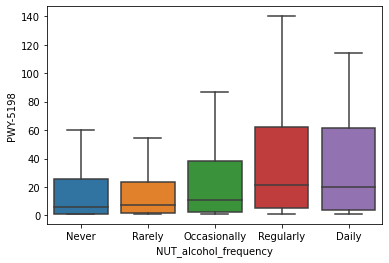

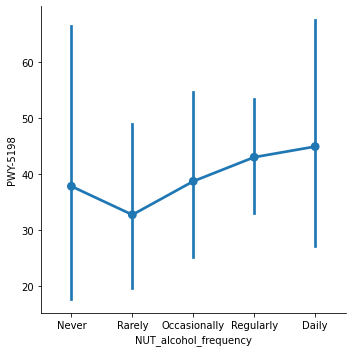

In [221]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-5198'], metadata['NUT_alcohol_frequency']],axis=1).dropna()
new_tab['NUT_alcohol_frequency'] = pd.Categorical(new_tab['NUT_alcohol_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)

sns.boxplot(data=new_tab, x='NUT_alcohol_frequency', y= 'PWY-5198', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_alcohol_frequency', y= 'PWY-5198', showfliers=False,
    kind="point"
)

<a id='milk'></a>
## 2. Test for Milk products

In [37]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_milk_cheese_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_milk_cheese.qzv

In [40]:
Visualization.load(f'{data_dir}/pa_ancom_milk_cheese.qzv')

<visualization: Visualization uuid: e638e2b9-0d6e-4a4d-a56b-f0f1396e7a5e>

ANCOM statistical result highest W value:  
NO significant features found!

In [39]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_milk_substitute_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_milk_substitute.qzv

In [8]:
Visualization.load(f'{data_dir}/pa_ancom_milk_substitute.qzv')

<visualization: Visualization uuid: b8062c1e-488b-42d2-a3da-245b5fffc9f9>

ANCOM statistical result highest W value:  
PWY-7315 -> 88  
PWY-3081 -> 14  
PWY-7446 -> 10  

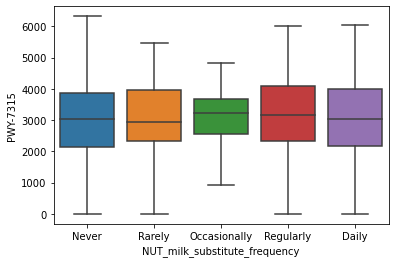

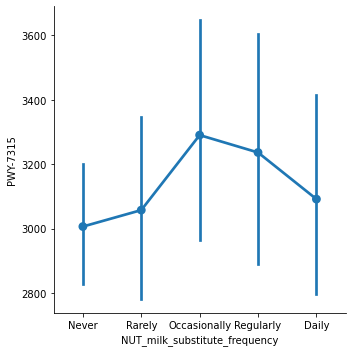

In [220]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-7315'], metadata['NUT_milk_substitute_frequency']],axis=1).dropna()
new_tab['NUT_milk_substitute_frequency'] = pd.Categorical(new_tab['NUT_milk_substitute_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)
sns.boxplot(data=new_tab, x='NUT_milk_substitute_frequency', y= 'PWY-7315', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_milk_substitute_frequency', y= 'PWY-7315', showfliers=False,
    kind="point"
)

In [48]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_vitamin_d_supplement_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_vitamin_d_supplement.qzv

Saved Visualization to: project_data/pa_ancom_vitamin_d_supplement.qzv


In [41]:
Visualization.load(f'{data_dir}/pa_ancom_vitamin_d_supplement.qzv')

<visualization: Visualization uuid: c29fbaab-6008-4f2b-95fe-50f81c2d2561>

ANCOM statistical result highest W value:  
NO significant features found!

<a id='mediterranean'></a>
## 3. Mediterranean Diet

In [52]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_olive_oil' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_olive_oil.qzv

Saved Visualization to: project_data/pa_ancom_olive_oil.qzv


In [13]:
Visualization.load(f'{data_dir}/pa_ancom_olive_oil.qzv')

<visualization: Visualization uuid: 845424b1-b1ee-4932-b5f0-94439d5fe781>

ANCOM statistical result highest W value:  
NO significant features found!

In [16]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_seafood_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_seafood.qzv

Visualization.load(f'{data_dir}/pa_ancom_seafood.qzv')

Saved Visualization to: project_data/pa_ancom_seafood.qzv


<visualization: Visualization uuid: 44bb2d93-d3b3-4fe8-a0d4-27be180c6cd8>

ANCOM statistical result highest W value:  
NO significant features found!

In [10]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_fruit_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_fruit.qzv

Saved Visualization to: project_data/pa_ancom_fruit.qzv


In [11]:
Visualization.load(f'{data_dir}/pa_ancom_fruit.qzv')

<visualization: Visualization uuid: 91681bac-b44a-4749-b827-021659127da0>

ANCOM statistical result highest W value:  
NO significant features found!

In [17]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_vegetable_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_vegetable.qzv

In [163]:
Visualization.load(f'{data_dir}/pa_ancom_vegetable.qzv')

<visualization: Visualization uuid: fefcf88e-fc19-4a29-8b82-ef2ede2cff02>

ANCOM statistical result highest W value:  
PWY-3801 -> 352  
PWY-6641 -> 341  
PWY-5941 -> 335  
CRNFORCAT-PWY -> 328  
SUCSYN-PWY -> 317  
PWY-5531 -> 316  
PWY-7159 -> 316  

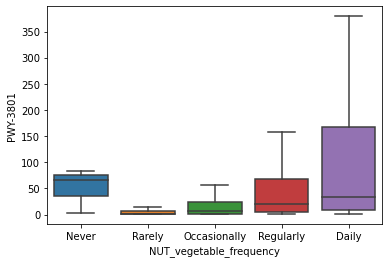

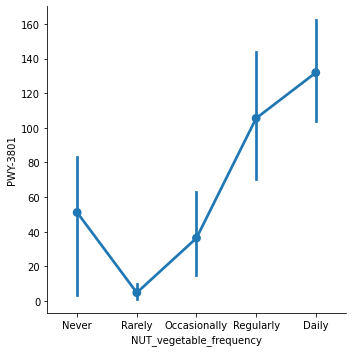

In [219]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-3801'], metadata['NUT_vegetable_frequency']],axis=1).dropna()
new_tab['NUT_vegetable_frequency'] = pd.Categorical(new_tab['NUT_vegetable_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)
sns.boxplot(data=new_tab, x='NUT_vegetable_frequency', y= 'PWY-3801', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_vegetable_frequency', y= 'PWY-3801', showfliers=False,
    kind="point"
)

In [18]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_whole_grain_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_whole_grain.qzv

Visualization.load(f'{data_dir}/pa_ancom_whole_grain.qzv')

Saved Visualization to: project_data/pa_ancom_whole_grain.qzv


<visualization: Visualization uuid: af7273c9-1f41-4d9b-893c-048881bf1f9a>

ANCOM statistical result highest W value:  
NO significant features found! 

<a id='poultry'></a>
## 4. Test for Poultry

In [14]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_poultry_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_poultry.qzv

Saved Visualization to: project_data/pa_ancom_poultry.qzv


In [15]:
Visualization.load(f'{data_dir}/pa_ancom_poultry.qzv')

<visualization: Visualization uuid: e1f99ad3-ef86-4ec8-9075-45aa9666db05>

ANCOM statistical result highest W value:   
PWY-5531 -> 210  
PWY-7159 -> 210  

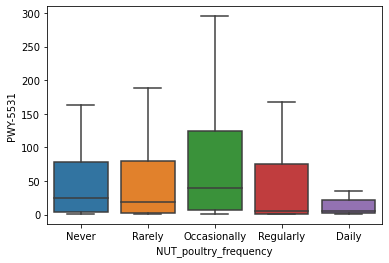

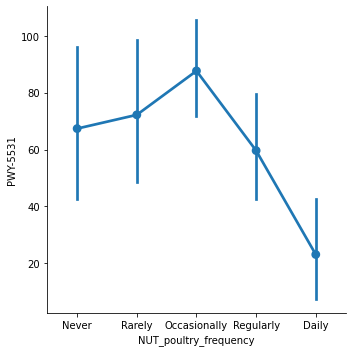

In [218]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-5531'], metadata['NUT_poultry_frequency']],axis=1).dropna()
new_tab['NUT_poultry_frequency'] = pd.Categorical(new_tab['NUT_poultry_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)

sns.boxplot(data=new_tab, x='NUT_poultry_frequency', y= 'PWY-5531', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_poultry_frequency', y= 'PWY-5531', showfliers=False,
    kind="point"
)

In [20]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_whole_eggs' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_whole_eggs.qzv

In [20]:
Visualization.load(f'{data_dir}/pa_ancom_whole_eggs.qzv')

Saved Visualization to: project_data/pa_ancom_whole_eggs.qzv


<visualization: Visualization uuid: 8446d5b3-5f7b-499e-8581-4eadc26ae0e8>

ANCOM statistical result highest W value:  
NO significant features found!

<a id='meat'></a>
## 5. Test for Meat

In [26]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_high_fat_red_meat_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_high_fat_red_meat.qzv

Visualization.load(f'{data_dir}/pa_ancom_high_fat_red_meat.qzv')

Saved Visualization to: project_data/pa_ancom_high_fat_red_meat.qzv


<visualization: Visualization uuid: ace39670-5b4e-4dc5-8922-e1d14b9c3d29>

ANCOM statistical result highest W value:  
NO significant features found!

In [33]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_red_meat_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_red_meat.qzv

Visualization.load(f'{data_dir}/pa_ancom_red_meat.qzv')

Saved Visualization to: project_data/pa_ancom_red_meat.qzv


<visualization: Visualization uuid: aa054bc8-e244-4c28-a81a-3319acfde9d1>

ANCOM statistical result highest W value:  
NO significant features found!

In [29]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_meat_eggs_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_meat_eggs.qzv

Visualization.load(f'{data_dir}/pa_ancom_meat_eggs.qzv')

Saved Visualization to: project_data/pa_ancom_meat_eggs.qzv


<visualization: Visualization uuid: 3f613e05-9748-4088-b042-b7cabd81dc90>

ANCOM statistical result highest W value:  
NO significant features found!

In [22]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_vitamin_b_supplement_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_vitamin_b.qzv

Visualization.load(f'{data_dir}/pa_ancom_vitamin_b.qzv')

Saved Visualization to: project_data/pa_ancom_vitamin_b.qzv


<visualization: Visualization uuid: 9bf49e61-e9c0-40b5-b02c-c241545a7480>

ANCOM statistical result highest W value:  
NO significant features found!

<a id='vegi'></a>
## 6. Vegetarian diet

In [36]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_diet_type' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_diet_type.qzv

In [7]:
Visualization.load(f'{data_dir}/pa_ancom_diet_type.qzv')

<visualization: Visualization uuid: a268d24f-ffdb-4bfd-b1ad-3ad0a7e70962>

ANCOM statistical result highest W value:  
PWY-6263 -> 72  
PWY-7374 -> 68  
PWY4FS-7 -> 54  
PWY4FS-8 -> 54  
GLYCOLYSIS-E-D -> 50

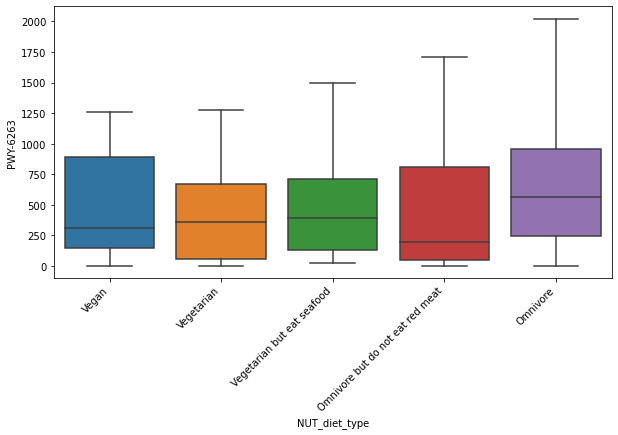

<Figure size 720x360 with 0 Axes>

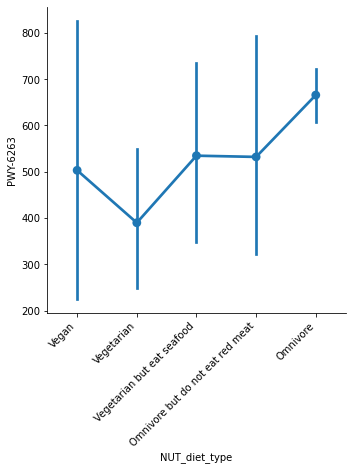

In [217]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-6263'], metadata['NUT_diet_type']],axis=1).dropna()
new_tab['NUT_diet_type'] = pd.Categorical(new_tab['NUT_diet_type'], 
                      categories=["Vegan", "Vegetarian", "Vegetarian but eat seafood", "Omnivore but do not eat red meat", "Omnivore"],
                      ordered=True)
plt.figure(figsize=(10,5))
chart = sns.boxplot(data=new_tab, x='NUT_diet_type', y= 'PWY-6263', showfliers=False)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.figure(figsize=(10,5))
chart2 = sns.catplot(
    data=new_tab, x='NUT_diet_type', y= 'PWY-6263', showfliers=False,
    kind="point")
chart2.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

<a id='gluten'></a>
## 7. Test for Gluten

In [19]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_gluten' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_gluten.qzv

In [162]:
Visualization.load(f'{data_dir}/pa_ancom_gluten.qzv')

<visualization: Visualization uuid: ecee8c97-05d8-4ba9-b5a2-ac661c19d1cc>

ANCOM statistical result highest W value:  
NO significant features found!

In [27]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_lowgrain_diet_type' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_lowgrain_diet_type.qzv

In [8]:
Visualization.load(f'{data_dir}/pa_ancom_lowgrain_diet_type.qzv')

<visualization: Visualization uuid: 04afc17f-6d45-49e0-83e9-19d04bf60ba1>

ANCOM statistical result highest W value:  
PWY-6383 -> 480  
PWY1G-0 -> 480  

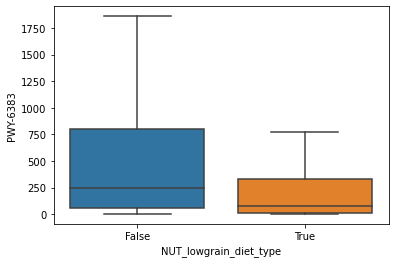

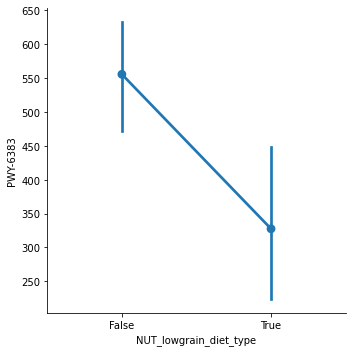

In [215]:
new_tab = pd.concat([tab['PWY-6383'], metadata['NUT_lowgrain_diet_type']],axis=1).dropna()
new_tab['NUT_lowgrain_diet_type']

sns.boxplot(data=new_tab, x="NUT_lowgrain_diet_type", y= "PWY-6383", showfliers=False)
sns.catplot(
    data=new_tab, x="NUT_lowgrain_diet_type", y= "PWY-6383", showfliers=False,
    kind="point"
)

<a id='sweet'></a>
## 8. Sweet Tooth

In [21]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_sugary_sweets_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_sugary_sweets.qzv

In [21]:
Visualization.load(f'{data_dir}/pa_ancom_sugary_sweets.qzv')

Saved Visualization to: project_data/pa_ancom_sugary_sweets.qzv


<visualization: Visualization uuid: 791c8501-c81d-4dd6-aabe-10166b502c92>

ANCOM statistical result highest W value:  
NO significant features found!

In [24]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_artificial_sweeteners' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_artificial_sweeteners.qzv

In [24]:
Visualization.load(f'{data_dir}/pa_ancom_artificial_sweeteners.qzv')

Saved Visualization to: project_data/pa_ancom_artificial_sweeteners.qzv


<visualization: Visualization uuid: 1afde280-5837-40c3-9e91-beb3bc5a4794>

ANCOM statistical result highest W value:  
NO significant features found!

In [35]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_frozen_dessert_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_frozen_dessert.qzv

In [35]:
Visualization.load(f'{data_dir}/pa_ancom_frozen_dessert.qzv')

Saved Visualization to: project_data/pa_ancom_frozen_dessert.qzv


<visualization: Visualization uuid: a2cc81d8-52c7-49a2-9bdb-3597aad2202c>

ANCOM statistical result highest W value:  
NO significant features found!

In [31]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_salted_snacks_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_salted_snacks.qzv

In [31]:
Visualization.load(f'{data_dir}/pa_ancom_salted_snacks.qzv')

Saved Visualization to: project_data/pa_ancom_salted_snacks.qzv


<visualization: Visualization uuid: 11aedd21-70a1-4813-aa05-bd6042c986b2>

ANCOM statistical result highest W value:  
PWY-6906 -> 63  
PWY-6641 -> 53  
PWY-6565 -> 26  

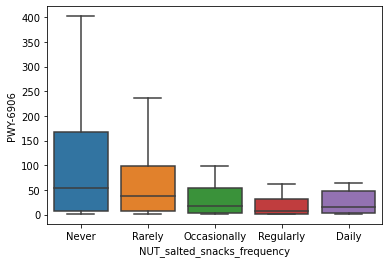

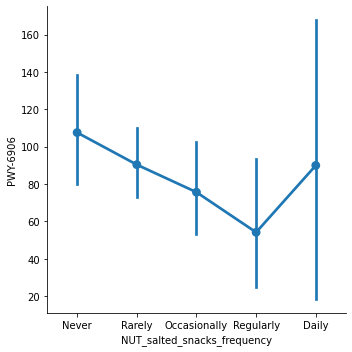

In [213]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-6906'], metadata['NUT_salted_snacks_frequency']],axis=1).dropna()

new_tab['NUT_salted_snacks_frequency'] = pd.Categorical(new_tab['NUT_salted_snacks_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)

sns.boxplot(data=new_tab, x='NUT_salted_snacks_frequency', y= 'PWY-6906', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_salted_snacks_frequency', y= 'PWY-6906', showfliers=False,
    kind="point"
)

<a id='probiotic'></a>
## 9. Fermented or Probiotic 

In [25]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_fermented_plant_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_fermented_plant.qzv

In [25]:
Visualization.load(f'{data_dir}/pa_ancom_fermented_plant.qzv')

Saved Visualization to: project_data/pa_ancom_fermented_plant.qzv


<visualization: Visualization uuid: 7e6934b9-5c9f-43f3-86e3-d709c63aac28>

ANCOM statistical result highest W value:  
GLYCOGENSYNTH-PWY -> 61  
PWY4FS-8 -> 26    
PWY4FS-7 -> 26  


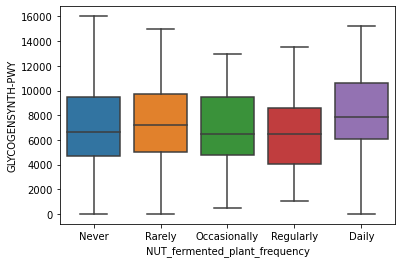

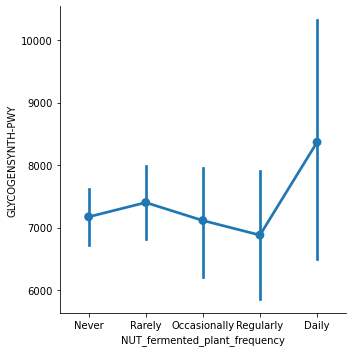

In [209]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['GLYCOGENSYNTH-PWY'], metadata['NUT_fermented_plant_frequency']],axis=1).dropna()
new_tab['NUT_fermented_plant_frequency'] = pd.Categorical(new_tab['NUT_fermented_plant_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)

sns.boxplot(data=new_tab, x='NUT_fermented_plant_frequency', y= 'GLYCOGENSYNTH-PWY', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_fermented_plant_frequency', y= 'GLYCOGENSYNTH-PWY', showfliers=False,
    kind="point"
)

In [23]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_probiotic_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_probiotic.qzv

In [23]:
Visualization.load(f'{data_dir}/pa_ancom_probiotic.qzv')

Saved Visualization to: project_data/pa_ancom_probiotic.qzv


<visualization: Visualization uuid: 954d1545-dbdd-4bc7-895b-b9c4d6ebd0ba>

ANCOM statistical result highest W value:  
PWY-6383 -> 456  
PWY1G-0 -> 449  


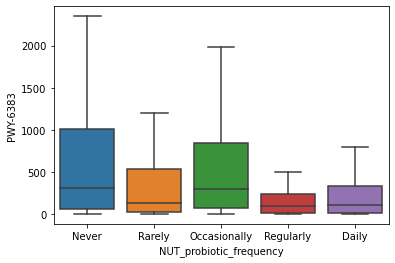

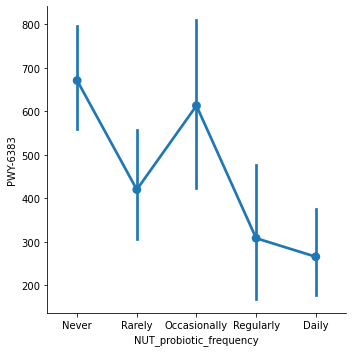

In [208]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-6383'], metadata['NUT_probiotic_frequency']],axis=1).dropna()
new_tab['NUT_probiotic_frequency'] = pd.Categorical(new_tab['NUT_probiotic_frequency'], 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)
sns.boxplot(data=new_tab, x='NUT_probiotic_frequency', y= 'PWY-6383', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_probiotic_frequency', y= 'PWY-6383', showfliers=False,
    kind="point"
)

<a id='rest'></a>
## XY. Test for Rest

In [30]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_prepared_meals_frequency' \
    --p-transform-function sqrt \
    --o-visualization $data_dir/pa_ancom_prepared_meals.qzv

In [4]:
Visualization.load(f'{data_dir}/pa_ancom_prepared_meals.qzv')

<visualization: Visualization uuid: 429ef5e6-120f-43bf-b023-c9d63c1d3bec>

ANCOM statistical result highest W value:   
PWY-5531 -> 363  
PWY-7159 -> 363  
PWY-5529 -> 335  

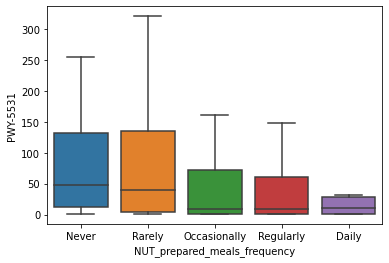

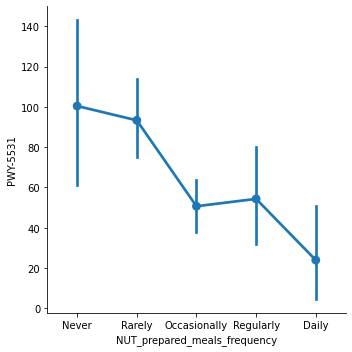

In [207]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-5531'], metadata['NUT_prepared_meals_frequency']],axis=1).dropna()
new_tab.NUT_prepared_meals_frequency = pd.Categorical(new_tab.NUT_prepared_meals_frequency, 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)
sns.boxplot(data=new_tab, x='NUT_prepared_meals_frequency', y= 'PWY-5531', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_prepared_meals_frequency', y= 'PWY-5531', showfliers=False,
    kind="point"
)

In [6]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --m-metadata-column 'NUT_homecooked_meals_frequency' \
    --p-transform-function clr \
    --o-visualization $data_dir/pa_ancom_homecooked_meals.qzv

Saved Visualization to: project_data/pa_ancom_homecooked_meals.qzv


In [7]:
Visualization.load(f'{data_dir}/pa_ancom_homecooked_meals.qzv')

<visualization: Visualization uuid: 8d8a6595-b774-46d0-be77-332d61681181>

ANCOM statistical result highest W value:  
PWY-5392 -> 51  
ILEUDEG-PWY -> 33  
PWY4FS-7 -> 9  
PWY4FS-8 -> 9

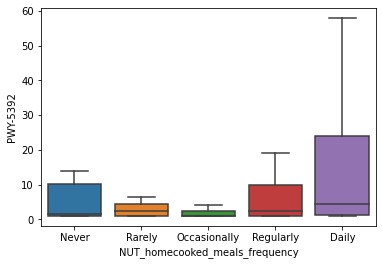

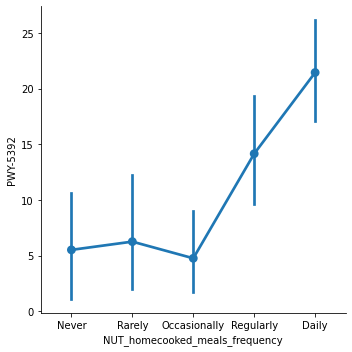

In [206]:
# Boxplot to show the data for the most significant pathway
new_tab = pd.concat([tab['PWY-5392'], metadata['NUT_homecooked_meals_frequency']],axis=1).dropna()
new_tab.NUT_homecooked_meals_frequency = pd.Categorical(new_tab.NUT_homecooked_meals_frequency, 
                      categories=["Never", "Rarely", "Occasionally", "Regularly", "Daily"],
                      ordered=True)
sns.boxplot(data=new_tab, x='NUT_homecooked_meals_frequency', y= 'PWY-5392', showfliers=False)
sns.catplot(
    data=new_tab, x='NUT_homecooked_meals_frequency', y='PWY-5392',
    kind="point", showfliers=False
)

In [5]:
! qiime composition ancom \
    --help

Usage: qiime composition ancom [OPTIONS]

  Apply Analysis of Composition of Microbiomes (ANCOM) to identify features
  that are differentially abundant across groups.

Inputs:
  --i-table ARTIFACT FeatureTable[Composition]
                       The feature table to be used for ANCOM computation.
                                                                    [required]
Parameters:
  --m-metadata-file METADATA
  --m-metadata-column COLUMN  MetadataColumn[Categorical]
                       The categorical sample metadata column to test for
                       differential abundance across.               [required]
  --p-transform-function TEXT Choices('sqrt', 'log', 'clr')
                       The method applied to transform feature values before
                       generating volcano plots.              [default: 'clr']
  --p-difference-function TEXT Choices('mean_difference', 'f_statistic')
                       The method applied to visualize fold difference in
       